# Introduction

Building up and keeping a loyal customer can be challenging for any company, especially when customers are free to choose from various providers within a product category. Furthermore, retaining existing customers is generally more cost-effective than acquiring new ones.
For this reason, evaluating user retention is crucial for business. It is essential to measure the level of customer satisfaction and measure the number of clients that will potentially stop the contract or make purchases with a company or service.
Customer churn, also known as customer attrition, is the percentage of customers that stopped using a company's service during a particular period. Keeping churn rates as low as possible is what every business pursuits. Identifying potential churners and influential features in advance allows the company to develop strategies to prevent customers from leaving. There are numerous ways a company can do to keep their customers. For example, offer incentives, like discounts or loyalty programs, provide additional services or engage with your user on social media in an attempt to reduce the churn rate. 

After identifying the potential churners, I will introduce the Survival Analysis and Customer Life Time Value Analysis. Why bother? It would be great to know every customer who will churn, but how much insight would that information really bring? And how would you know when and what to focus on if you wanted to keep them and how much you could spend to keep them before having them as a customer turned into a loss? Our churn prediction model provides no clear answer as to what time scale it is predicting for. And this is when Survival Analysis and Customer Life Time Value Analysis come into play. The former allows us to model the time to an event(churn). The latter gives us crucial insights into how much money we should be spending on acquiring the customers by calculating how much value they'll bring to the business in the long run. Rather than just racing to keep my head above water, I would like to understand which customers I should be focusing on and, more importantly, why I should be focusing on them. Let's begin!

# Import modules

In [2]:
import numpy as np
import pandas as pd
import random
import os
import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import missingno as msno

import lifelines
from lifelines.utils import median_survival_times
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Load data

In [10]:
user_data_sample = pd.read_csv('data_kkbox/kkbox_user_data_sample.csv')

user_data_sample.loc[:, 'transaction_date'] = pd.to_datetime(user_data_sample['transaction_date'], format='%Y-%m-%d')
user_data_sample.loc[:, 'membership_expire_date'] = pd.to_datetime(user_data_sample['membership_expire_date'], format='%Y-%m-%d')
user_data_sample.loc[:, 'registration_init_time'] = pd.to_datetime(user_data_sample['registration_init_time'], format='%Y-%m-%d')
user_data_sample.loc[:, 'first_month'] = pd.to_datetime(user_data_sample['first_month'], format='%Y-%m-%d')
user_data_sample.loc[:, 'transaction_date_floor'] = pd.to_datetime(user_data_sample['transaction_date_floor'], format='%Y-%m-%d')

In [5]:
user_data_sample.head()

msno  payment_method_id  \
0  ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
1  ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
2  ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
3  ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
4  ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                 31              149                 149              1   
1                 31              149                 149              1   
2                 31              149                 149              1   
3                  0                0                 149              1   
4                 30              149                 149              1   

  transaction_date membership_expire_date  is_cancel  is_churn  city  bd  \
0       2015-01-31             2015-03-23          0         0    22  32   
1       2015-02-28             2015-04-23          0         0    22  32   
2       2015-03-31             2015-05-23          0         0    22  32   
3       2015-04-30             2015-06-23          0         0    22  32   
4       2015-05-31             2015-07-23          0         0    22  32   

  gender  registered_via registration_init_time  days_between_trans  \
0   male               9             2012-01-22                   0   
1   male               9             2012-01-22                   0   
2   male               9             2012-01-22                   0   
3   male               9             2012-01-22                   0   
4   male               9             2012-01-22                   0   

  transaction_date_floor first_month  month_after_fist_day  
0             2015-01-01  2015-01-01                     0  
1             2015-02-01  2015-01-01                     1  
2             2015-03-01  2015-01-01                     2  
3             2015-04-01  2015-01-01                     3  
4             2015-05-01  2015-01-01                     4

In [88]:
user_data_sample.shape

(1704672, 19)

# Define some helper functions 

In [8]:
def plot_style_setting(figsize=[10, 6]):
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['axes.labelpad'] = 10
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['font.family'] = "monospace"
    params = {i:'#595959' for i in ["axes.titlecolor", "ytick.color", "xtick.color","axes.labelcolor","text.color"]}
    plt.rcParams.update(params)

# Handle outliers by using zscore
def replaceoutlier(df, col):
    mean, std = np.mean(df[col]), np.std(df[col])
    cut_off = std*3
    lower, upper = mean - cut_off, mean + cut_off
    result_df = df[(df[col] >= lower) & (df[col] <= upper)]
    return result_df


def get_feature_out(Preprocessor, features):
    if hasattr(Preprocessor,'get_feature_names'):
        return Preprocessor.get_feature_names(features)
    else:
        return features
    
def get_ct_feature_names(ct):
    output_features = []
    
    for name, Preprocessor, features in ct.transformers_:
        if name!='remainder':
            if isinstance(Preprocessor, Pipeline):
                current_features = features
                for step in Preprocessor:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(Preprocessor, features)
            output_features.extend(features_out)
        elif Preprocessor=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

def listening_type(x):
    result = []
    total = x[['num_25','num_50', 'num_75', 'num_985', 'num_100']].mean().sum()
    if x[['num_985', 'num_100']].mean().sum() / total >= 0.8:
        return 'loyalist_type'
    elif x[['num_25','num_50']].mean().sum() / total >= 0.8:
        return 'switcher_type'
    else:
        return 'normal_type'

# User churn prediction

In this section, my goal is to predict whether or not a customer will churn based on various features that I created previously. I will be using supervised machine learning techniques to make predictions. Before the modeling process, I also conducted a simple exploratory data analysis and feature engineering to create some insightful new features. Notice that I won't dig too deep in terms of data exploration. I am doing the complete and extensive exploratory data analysis of this data on another project, which will be posted soon.

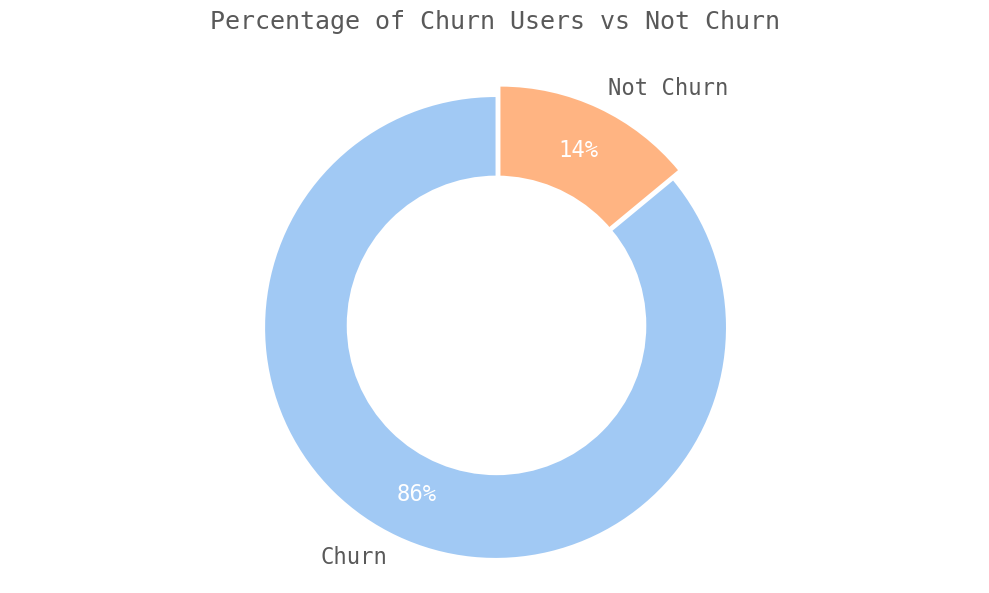

In [365]:
name = ['Churn', 'Not Churn']
churn = [0.86, 0.14]
_, _, autotexts = plt.pie(churn, labels=name, autopct='%0.f%%', colors = sns.color_palette('pastel').as_hex(), shadow=False, startangle=90, pctdistance=0.80, explode =(0.01, 0.04), textprops={'fontsize':16}) 
[autotext.set_color('white') for autotext in autotexts]
    
plt.title('Percentage of Churn Users vs Not Churn', 
          fontsize=18,
          y=1.05, 
          color='#595959',
          fontname='monospace')
circle = plt.Circle((0,0),0.65, fc='white') 
donut = plt.gcf()
donut.gca().add_artist(circle)
plt.axis('equal')
plt.tight_layout()
plt.savefig('num_churn', dpi=150, bbox_inches='tight')

## Feature engineering

In [9]:
# Days between transactions
user_data_sample['transaction_date_shift'] = user_data_sample.groupby(['msno'], as_index=False)['transaction_date'].shift(-1) 
user_data_sample['days_between_trans'] = (user_data_sample['transaction_date_shift'] - user_data_sample['membership_expire_date'])
snapshot_date = user_data_sample['transaction_date'].max()
user_data_sample['days_between_trans'] = user_data_sample.set_index('msno')['days_between_trans']\
                                                         .fillna(snapshot_date - user_data_sample\
                                                         .groupby('msno')['membership_expire_date'].max())\
                                                         .apply(lambda x: 0 if x.days <= 0 else x.days)\
                                                         .to_list()
user_data_sample.drop('transaction_date_shift', axis=1, inplace=True)

In [10]:
# Filter to exclude the outliers
user_data_out_rm_z = user_data_sample.copy()
for col in ['plan_list_price', 'actual_amount_paid', 'payment_plan_days']:
    user_data_out_rm_z = replaceoutlier(user_data_out_rm_z, col)
user_data_out_rm_z

msno  payment_method_id  \
0        ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
1        ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
2        ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
4        ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
5        ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                 39   
...                                               ...                ...   
1707958  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=                 39   
1707959  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=                 39   
1707960  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=                 39   
1707961  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=                 39   
1707962  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=                 39   

         payment_plan_days  plan_list_price  actual_amount_paid  \
0                       31              149                 149   
1                       31              149                 149   
2                       31              149                 149   
4                       30              149                 149   
5                       30              149                 149   
...                    ...              ...                 ...   
1707958                 30              149                 149   
1707959                 30              149                 149   
1707960                 30              149                 149   
1707961                 30              149                 149   
1707962                 30              149                 149   

         is_auto_renew transaction_date membership_expire_date  is_cancel  \
0                    1       2015-01-31             2015-03-23          0   
1                    1       2015-02-28             2015-04-23          0   
2                    1       2015-03-31             2015-05-23          0   
4                    1       2015-05-31             2015-07-23          0   
5                    1       2015-06-30             2015-08-23          0   
...                ...              ...                    ...        ...   
1707958              1       2016-11-30             2017-01-24          0   
1707959              1       2016-12-31             2017-02-24          0   
1707960              1       2017-01-31             2017-03-24          0   
1707961              1       2017-02-28             2017-04-24          0   
1707962              1       2017-03-31             2017-05-24          0   

         is_churn  city  bd  gender  registered_via registration_init_time  \
0               0    22  32    male               9             2012-01-22   
1               0    22  32    male               9             2012-01-22   
2               0    22  32    male               9             2012-01-22   
4               0    22  32    male               9             2012-01-22   
5               0    22  32    male               9             2012-01-22   
...           ...   ...  ..     ...             ...                    ...   
1707958         0     4  48  female               9             2014-06-11   
1707959         0     4  48  female               9             2014-06-11   
1707960         0     4  48  female               9             2014-06-11   
1707961         0     4  48  female               9             2014-06-11   
1707962         0     4  48  female               9             2014-06-11   

         days_between_trans  
0                         0  
1                         0  
2                         0  
4                         0  
5                         0  
...                     ...  
1707958                   0  
1707959                   0  
1707960                   0  
1707961                   0  
1707962                   0  

[1569287 rows x 16 columns]

In [11]:
snap = user_data_sample['membership_expire_date'].max()
user_data_agg = user_data_sample.groupby('msno', as_index=False)\
                                .apply(lambda x: pd.Series({
    'no_records': x['msno'].count(),
    'payment_method_id': x['payment_method_id'].mode().values[0],
    'avg_amount_paid': x['actual_amount_paid'].mean(),
    'tenure':(x['membership_expire_date'] - x['registration_init_time']).max().days if x['is_churn'].max() == 1 else (snap - x['registration_init_time']).max().days,
    'days_to_first_trans': (x['transaction_date'] - x['registration_init_time']).min().days,
    'days_between_trans': x['days_between_trans'].sum(),
    'is_auto_renew': x['is_auto_renew'].mode().values[0],
    'city': x['city'].mode().iloc[0],
    'bd': x['bd'].mode().values[0],
    'gender': x['gender'].mode().values[0],
    'registered_via': x['registered_via'].mode().values[0],
    'is_auto_renew': x['is_auto_renew'].mode().values[0],
    'is_churn': x['is_churn'].max()
    })
    )

In [14]:
# Note that user_log_sample is a data set that joins the user_log and user_data_agg. Since user_log is a extremely large data set and will take a great deal of time to process, I will directly provide the result for you.
# Aggregate the data to an individual level 
user_log_sample = pd.read_csv('data_kkbox/user_log_sample.csv')
user_log_sample['date'] = pd.to_datetime(user_log_sample['date'], format='%Y-%m-%d')
user_log_agg = user_log_sample.groupby('msno', as_index=False)\
                              .apply(lambda x: pd.Series({
    'avg_songs_daily': x[['num_25','num_50', 'num_75', 'num_985', 'num_100']].mean().sum(),
    'uniq_rate': x['num_unq'].mean() / x[['num_25','num_50', 'num_75', 'num_985', 'num_100']].mean().sum(),
    'avg_secs_daily': x['total_secs'].mean(),
    'median_secs_daily': x['total_secs'].median(),
    'listening_type': listening_type(x)
    })
    )
user_log_agg

msno  avg_songs_daily  \
0      ++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=        11.095238   
1      ++4cUL0b9CfW8cj0A/wfSxQc4k4fcVtWcLqk2UOdpKs=       119.354839   
2      ++6P09mCSJSh+Ft2pvZ0FWTrtcI3v1A7h3/coh8dBKw=         4.666667   
3      ++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=        14.000000   
4      ++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=        49.285714   
...                                             ...              ...   
89553  zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=        14.678571   
89554  zzmb2gX4F9mK0G1+2YQ8pqdYrPizIo0o+MNUA9+5I1I=        15.880000   
89555  zzwimfmJBJ4SrRw3bYXQzE9UrizlSE10yI7dHPvG5xM=        21.000000   
89556  zzwlIVmSuehTevzOi+WkcC7b3+MBYDiE4qybszTyhII=        38.870968   
89557  zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=        14.200000   

       uniq_rate  avg_secs_daily  median_secs_daily listening_type  
0       0.957082     1744.601810          1535.2280    normal_type  
1       0.950811    30179.330000         35140.3090  loyalist_type  
2       1.000000      998.315667           949.2300  loyalist_type  
3       0.585034     2753.949571          1697.0160    normal_type  
4       0.924638    11683.843000          8891.2260  loyalist_type  
...          ...             ...                ...            ...  
89553   0.824818     2842.891714          2680.0385  loyalist_type  
89554   0.732997     2927.222080          2541.2690    normal_type  
89555   1.000000     4700.720000          4700.7200  loyalist_type  
89556   0.751037     8012.149581          7332.4170  loyalist_type  
89557   0.845070     3047.686250          2271.1370  loyalist_type  

[89558 rows x 6 columns]

## Convert the categorical data

In [16]:
# Transform gender column
user_features['is_male'] = user_features['gender']\
                                    .apply(lambda x: 1 if x == 'male' else 0)

# Create age bins
user_features = user_features[(user_features.bd <= 100) & (user_features.bd >= 5)]
bin_label= ['5_11', '12_18', '19_25', '26_35', '36_45', '46_60', '61_100']
cut_bins = [5, 11, 18, 25, 35, 45, 60, 100]
user_features['age_bin'] = pd.cut(user_features['bd'], bins=cut_bins, labels=bin_label)

# Filter to only contain payment method with count larger than 10
payment_filter = user_features.payment_method_id.value_counts()[user_features.payment_method_id.value_counts(normalize=True) > 0.001].index.to_list()
user_features = user_features[user_features.payment_method_id.isin(payment_filter)]

# Drop the original columns
user_features.drop(['gender'], axis=1, inplace=True)
user_features.drop(['bd'], axis=1, inplace=True)

# Drop the NaN values
user_features.dropna(inplace=True)

In [178]:
# Separate numerical and categorical columns
userid = ['msno']
target = ['is_churn']
cat_cols = ['listening_type', 'city', 'payment_method_id', 'registered_via', 'age_bin']
cat_num_cols = ['is_auto_renew', 'is_male']
num_cols = [col for col in user_features.columns.tolist() if col not in cat_cols + userid + target + cat_num_cols]

In [179]:
ct = ColumnTransformer(
    [("scaling", StandardScaler(), num_cols),
     ("onehot", OneHotEncoder(sparse=False), cat_cols)], 
    remainder="passthrough")

In [180]:
# get all columns apart from income for the features
X_features = user_features.drop(userid+target, axis=1)

# split dataframe and income
X_train, X_test, y_train, y_test = train_test_split(
    X_features, user_features.is_churn, random_state=0, stratify=user_features.is_churn)

X_train_trans = ct.fit_transform(X_train)
print(X_train_trans.shape)

(64868, 72)


## Define and deploy models

### Churn Prediction with Logistics Regression

In [183]:
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
logreg_pred = logreg.predict(X_test_trans)
f1_logreg = f1_score(logreg_pred, y_test)
print("Train score: {:.2f}".format(logreg.score(X_train_trans, y_train)))
print("Test score: {:.2f}\n".format(logreg.score(X_test_trans, y_test)))
print(f'Clssification Report:\n {classification_report(logreg_pred, y_test)}')

Train score: 0.98
Test score: 0.97

Clssification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     19649
           1       0.81      0.94      0.87      1974

    accuracy                           0.97     21623
   macro avg       0.90      0.96      0.93     21623
weighted avg       0.98      0.97      0.98     21623



In [175]:
result_eval_df

accuracy   roc_auc        f1
LogisticRegression          0.960890  0.957115  0.792789
DecisionTreeClassifier      0.938968  0.838847  0.677483
RandomForestClassifier      0.927730  0.918080  0.513153
GradientBoostingClassifier  0.939385  0.937659  0.614496
XGBoostClassifier           0.986912  0.996717  0.935449

Optimization terminated successfully.
         Current function value: 0.129583
         Iterations 9


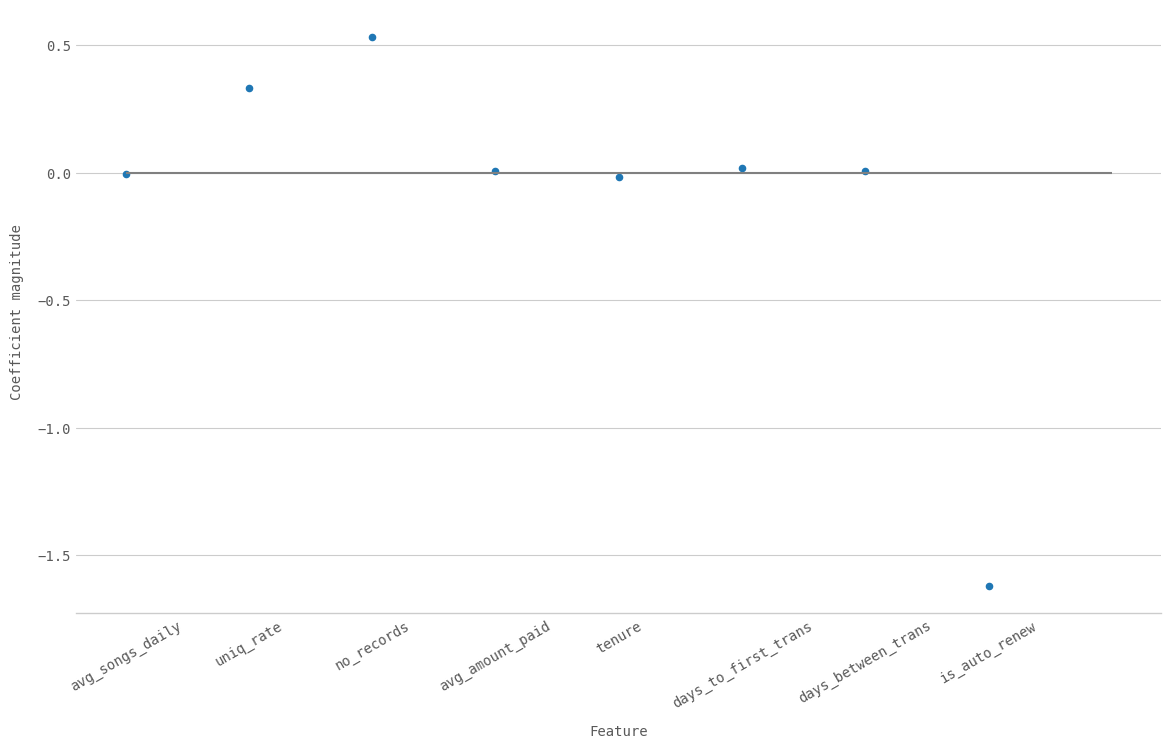

In [222]:
# # Select the check features that are statistically significant 
# model = sm.Logit(y_train, X_train)
# model_fit = model.fit()


# sm_logreg_result = pd.concat([model_fit.params, model_fit.pvalues], axis=1).reset_index()
# sm_logreg_result.columns = ['feature', 'coef', 'pvalue']
# sm_logreg_result_sig = sm_logreg_result[sm_logreg_result.pvalue <= 0.05][['feature', 'coef']].reset_index()
# sm_logreg_result_sig

# plot_style_setting()
# sm_logreg_result_sig.plot('feature', 'coef', kind='scatter', figsize=(14,8))
# plt.xticks(rotation=30)
# plt.hlines(0, 0, sm_logreg_result_sig.shape[0], color='gray')
# plt.xlabel("Feature")
# plt.ylabel("Coefficient magnitude")
# plt.grid(axis='x')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

## Churn Prediction with Decision Tree

In [205]:
dummy_df = pd.get_dummies(user_features[cat_cols].astype(str))
dt_features = user_features.drop(cat_cols, axis=1)
dt_features = pd.concat([dt_features, dummy_df], axis=1).drop(userid+target, axis=1)
dt_features

avg_songs_daily  uniq_rate  avg_secs_daily  median_secs_daily  \
0            11.095238   0.957082     1744.601810          1535.2280   
1           119.354839   0.950811    30179.330000         35140.3090   
2             4.666667   1.000000      998.315667           949.2300   
3            14.000000   0.585034     2753.949571          1697.0160   
4            49.285714   0.924638    11683.843000          8891.2260   
...                ...        ...             ...                ...   
86486        14.678571   0.824818     2842.891714          2680.0385   
86487        15.880000   0.732997     2927.222080          2541.2690   
86488        21.000000   1.000000     4700.720000          4700.7200   
86489        38.870968   0.751037     8012.149581          7332.4170   
86490        14.200000   0.845070     3047.686250          2271.1370   

       no_records  avg_amount_paid  tenure  days_to_first_trans  \
0              21       149.000000    2170                 1105   
1              29       135.241379    1909                  821   
2              21       149.000000    2658                 1593   
3              22       149.000000    2037                  965   
4              27       149.000000    1117                   30   
...           ...              ...     ...                  ...   
86486          30       129.666667    1439                  364   
86487           9       331.111111    1923                  996   
86488           6        99.000000     437                    0   
86489          12       156.750000     624                    0   
86490          18       149.000000    1299                  247   

       days_between_trans  is_auto_renew  ...  registered_via_4  \
0                     138              1  ...                 0   
1                      56              1  ...                 0   
2                     158              1  ...                 0   
3                     146              1  ...                 0   
4                      21              1  ...                 0   
...                   ...            ...  ...               ...   
86486                  28              1  ...                 0   
86487                   9              1  ...                 0   
86488                   0              1  ...                 0   
86489                   2              1  ...                 1   
86490                 272              1  ...                 0   

       registered_via_7  registered_via_9  age_bin_12_18  age_bin_19_25  \
0                     0                 1              0              0   
1                     1                 0              0              0   
2                     0                 1              0              0   
3                     0                 0              0              0   
4                     0                 1              0              1   
...                 ...               ...            ...            ...   
86486                 1                 0              0              1   
86487                 0                 1              0              0   
86488                 1                 0              0              0   
86489                 0                 0              0              0   
86490                 0                 1              0              0   

       age_bin_26_35  age_bin_36_45  age_bin_46_60  age_bin_5_11  \
0                  1              0              0             0   
1                  1              0              0             0   
2                  1              0              0             0   
3                  1              0              0             0   
4                  0              0              0             0   
...              ...            ...            ...           ...   
86486              0              0              0             0   
86487              1              0              0             0   
86488              

In [206]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    dt_features, user_features.is_churn, random_state=0, stratify=user_features.is_churn)

In [207]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
print("Train score: {:.2f}".format(dt.score(X_train, y_train)))
print("Test score: {:.2f}\n".format(dt.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(dt_pred, y_test)}')

Train score: 1.00
Test score: 0.94

Clssification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     19359
           1       0.71      0.72      0.72      2264

    accuracy                           0.94     21623
   macro avg       0.84      0.85      0.84     21623
weighted avg       0.94      0.94      0.94     21623



In [208]:
depth_list = np.arange(2, 20).tolist()
depth_tuning = np.zeros((len(depth_list), 2))
depth_tuning[:, 0] = depth_list

# Run a for loop over the range of depth list length
for index in range(0, len(depth_list)):
  # Initialize and fit decision tree with the `max_depth` candidate
  dt = DecisionTreeClassifier(max_depth=depth_list[index])
  dt.fit(X_train, y_train)
  # Predict churn on the testing data
  dt_pred_Y = dt.predict(X_test)
  # Calculate the recall score 
  depth_tuning[index,1] = f1_score(y_test, dt_pred_Y)

# Name the columns and print the array as pandas DataFrame
col_names = ['Max_Depth','f1']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth        f1
0         2.0  0.334767
1         3.0  0.353819
2         4.0  0.395740
3         5.0  0.395045
4         6.0  0.426534
5         7.0  0.451466
6         8.0  0.453481
7         9.0  0.490165
8        10.0  0.530539
9        11.0  0.546917
10       12.0  0.578677
11       13.0  0.595769
12       14.0  0.620253
13       15.0  0.634082
14       16.0  0.660480
15       17.0  0.666328
16       18.0  0.683086
17       19.0  0.693275


In [209]:
dt = DecisionTreeClassifier(max_depth=19)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
f1_dt = f1_score(dt_pred, y_test)
print("Train score: {:.2f}".format(dt.score(X_train, y_train)))
print("Test score: {:.2f}\n".format(dt.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(dt_pred, y_test)}')

Train score: 0.98
Test score: 0.94

Clssification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     19803
           1       0.62      0.79      0.69      1820

    accuracy                           0.94     21623
   macro avg       0.80      0.87      0.83     21623
weighted avg       0.95      0.94      0.94     21623



## Churn Prediction with Random Forest

In [210]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
print("Train score: {:.2f}".format(rf.score(X_train, y_train)))
print("Test score: {:.2f}\n".format(rf.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(rf_pred, y_test)}')

Train score: 1.00
Test score: 0.93

Clssification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     20722
           1       0.35      0.90      0.50       901

    accuracy                           0.93     21623
   macro avg       0.67      0.91      0.73     21623
weighted avg       0.97      0.93      0.94     21623



In [101]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 190.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [211]:
rf_random_pred = rf_random.predict(X_test)
f1_rf = f1_score(rf_random_pred, y_test)
print("Train score: {:.2f}".format(rf_random.score(X_train, y_train)))
print("Test score: {:.2f}\n".format(rf_random.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(rf_random_pred, y_test)}')

Train score: 1.00
Test score: 0.93

Clssification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     20635
           1       0.39      0.91      0.55       988

    accuracy                           0.93     21623
   macro avg       0.69      0.92      0.75     21623
weighted avg       0.97      0.93      0.94     21623



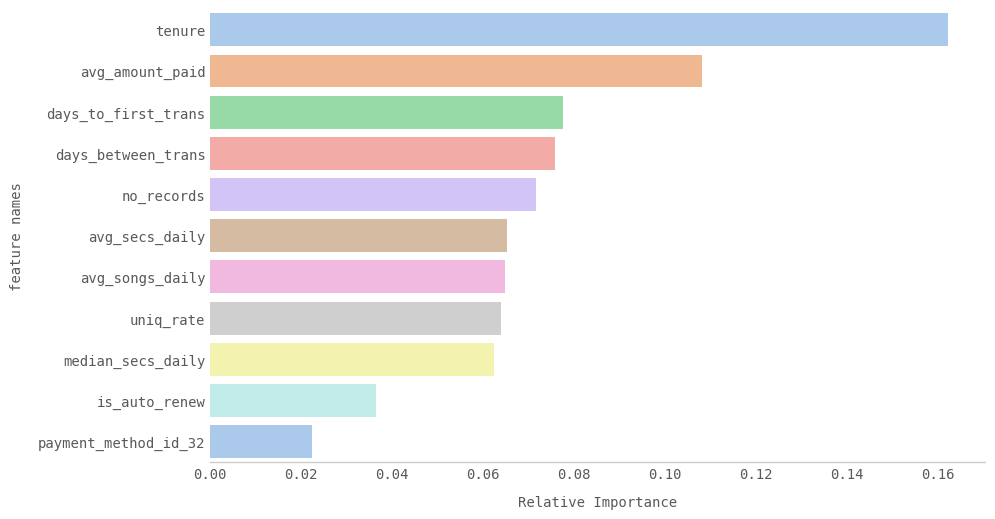

In [30]:
# Store the vlaues in a DataFrame
ft_df = pd.DataFrame(zip(dt_features.columns, rf.feature_importances_), columns=['feature names', 'feature_importance'])

# Plot the result
g = sns.barplot(x='feature_importance', 
                y='feature names', 
                data=ft_df.query('feature_importance >= 0.02').sort_values('feature_importance', ascending=False),
                palette='pastel')
_ = g.set(xlabel='Relative Importance')
sns.despine(left=True)

## Permutation Feature importance 

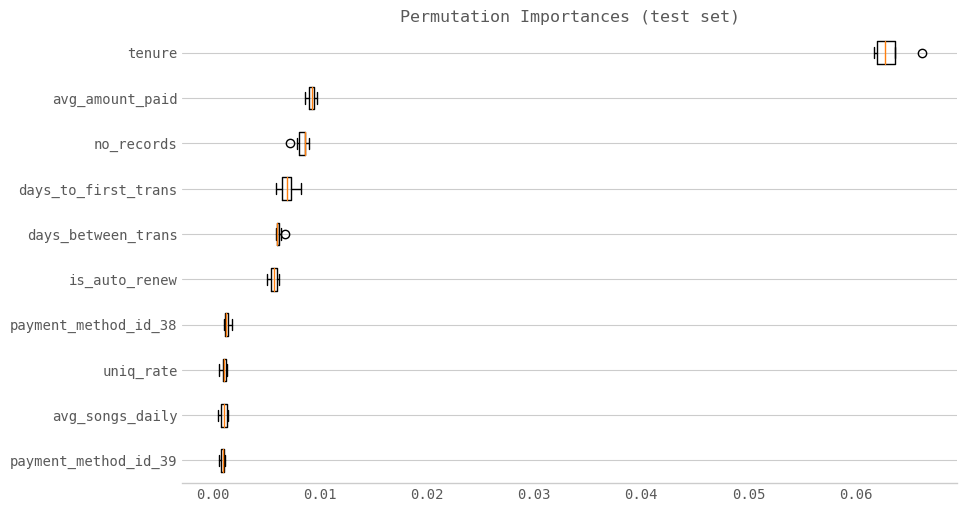

In [53]:
permutation_importance_df = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = permutation_importance_df.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(permutation_importance_df.importances[sorted_idx][-10:].T,
           vert=False, labels=X_test.columns[sorted_idx][-10:])
ax.set_title("Permutation Importances (test set)")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

## Churn Prediction with Gradient Boosting Classifier

In [214]:
gb = GradientBoostingClassifier()
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest()
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train_masked, y_train_masked = X_train[mask], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train_masked.shape, y_train_masked.shape)

gb.fit(X_train_masked, y_train_masked)
gb_pred = gb.predict(X_test)
f1_gb = f1_score(gb_pred, y_test)
print("Train score: {:.2f}".format(gb.score(X_train_masked, y_train_masked)))
print("Test score: {:.2f}\n".format(gb.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(gb_pred, y_test)}')

(64868, 70) (64868,)
(64822, 70) (64822,)
Train score: 0.94
Test score: 0.94

Clssification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     20553
           1       0.44      0.94      0.60      1070

    accuracy                           0.94     21623
   macro avg       0.72      0.94      0.78     21623
weighted avg       0.97      0.94      0.95     21623



## Churn Prediction with Xgboost

In [213]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
f1_xgb = f1_score(xgb_pred, y_test)
print("Train score: {:.2f}".format(xgb.score(X_train, y_train)))
print("Test score: {:.2f}\n".format(xgb.score(X_test, y_test)))
print(f'Clssification Report:\n {classification_report(xgb_pred, y_test)}')

[22:19:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score: 1.00
Test score: 0.99

Clssification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19507
           1       0.91      0.99      0.95      2116

    accuracy                           0.99     21623
   macro avg       0.95      0.99      0.97     21623
weighted avg       0.99      0.99      0.99     21623



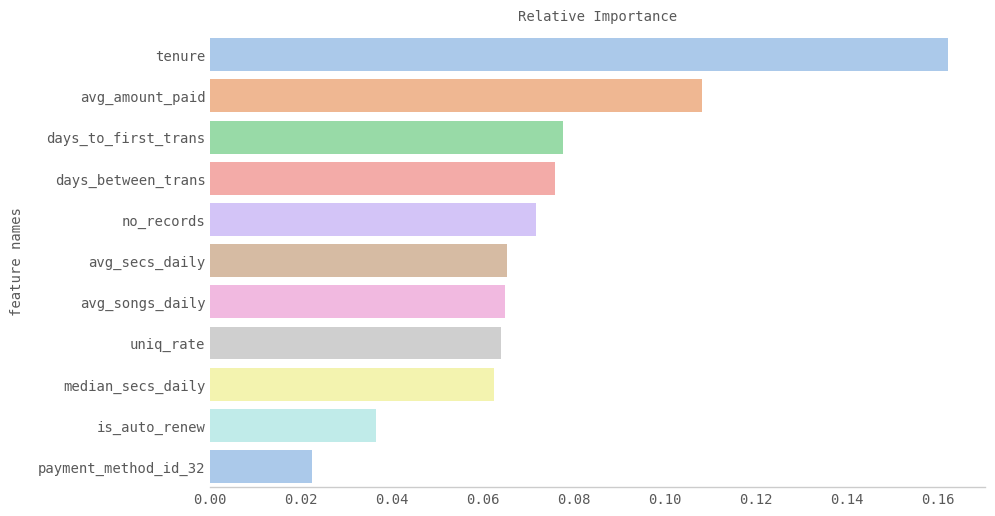

In [315]:
# Store the vlaues in a DataFrame
xgb_df = pd.DataFrame(zip(dt_features.columns, xgb.feature_importances_), columns=['feature names', 'feature_importance'])

# Plot the result
g_fi = sns.barplot(x='feature_importance', 
                y='feature names', 
                data=ft_df.query('feature_importance >= 0.02').sort_values('feature_importance', ascending=False),
                palette='pastel')
g_fi.set(xlabel='Relative Importance')
g_fi.xaxis.set_label_position('top')
sns.despine(left=True)
plt.savefig('fi', dpi=150, bbox_inches='tight')

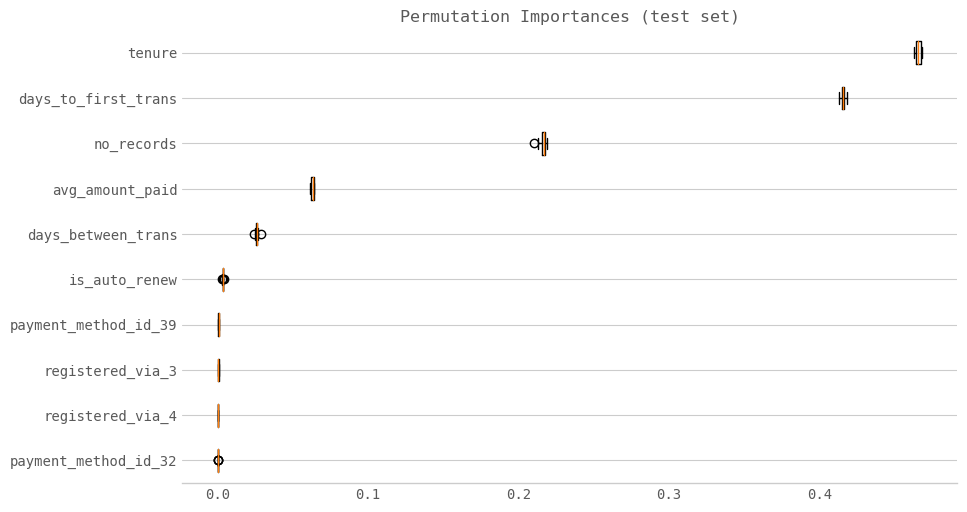

In [309]:
xgb_permutation_importance_df = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = xgb_permutation_importance_df.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(xgb_permutation_importance_df.importances[sorted_idx][-10:].T,
           vert=False, labels=X_test.columns[sorted_idx][-10:])
ax.set_title("Permutation Importances (test set)")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('pi', dpi=150, bbox_inches='tight')

In [ ]:
# Store the vlaues in a DataFrame
xgb_ft_df = pd.DataFrame(zip(dt_features.columns, xgb.feature_importances_), columns=['feature names', 'feature_importance'])

# Plot the result
g2 = sns.barplot(x='feature_importance', 
                y='feature names', 
                data=xgb_ft_df.query('feature_importance >= 0.02').sort_values('feature_importance', ascending=False),
                palette='pastel')
_ = g2.set(xlabel='Relative Importance')
sns.despine(left=True)

In [ ]:
plot_style_setting()
sns.heatmap(user_features.corr(), annot = True, annot_kws={'fontsize':8}, fmt='.2f', cmap=sns.light_palette("seagreen", as_cmap=True))

## Measure the Final result

In [220]:
result_eval_df = pd.DataFrame(columns=['val_accuracy', 'val_roc_auc', 'val_f1', 'test_accuracy', 'test_f1'])
logreg_scores = cross_validate(logreg, X_train_trans, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
dt_scores = cross_validate(dt, X_train, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
rf_scores = cross_validate(rf, X_train, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
gb_scores = cross_validate(gb, X_train, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
xgb_scores = cross_validate(xgb, X_train, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
clf_dict = {'LogisticRegression':logreg_scores, 'DecisionTreeClassifier':dt_scores, 'RandomForestClassifier':rf_scores, 'GradientBoostingClassifier':gb_scores, 'XGBoostClassifier':xgb_scores}
clf_dict_test_score = {'LogisticRegression': {'acc': logreg.score(X_test_trans, y_test), 'f1':f1_logreg}, 
'DecisionTreeClassifier':{'acc': dt.score(X_test, y_test), 'f1':f1_dt}, 
'RandomForestClassifier':{'acc': rf.score(X_test, y_test), 'f1':f1_rf}, 
'GradientBoostingClassifier':{'acc': gb.score(X_test, y_test), 'f1':f1_gb}, 
'XGBoostClassifier':{'acc': xgb.score(X_test, y_test), 'f1':f1_xgb}}

for k,v in clf_dict.items():
    result_eval_df.loc[k] = v['test_accuracy'].mean(), v['test_roc_auc'].mean(), v['test_f1'].mean(), clf_dict_test_score[k]['acc'], clf_dict_test_score[k]['f1']


In [219]:
result_eval_df

val_accuracy  val_roc_auc    val_f1  \
LogisticRegression              0.960890     0.957115  0.792789   
DecisionTreeClassifier          0.938968     0.838847  0.677483   
RandomForestClassifier          0.927730     0.918080  0.513153   
GradientBoostingClassifier      0.939385     0.937659  0.614496   
XGBoostClassifier               0.986912     0.996717  0.935449   

                            test_accuracy   test_f1  
LogisticRegression               0.974333  0.870357  
DecisionTreeClassifier           0.941682  0.694451  
RandomForestClassifier           0.926467  0.545068  
GradientBoostingClassifier       0.937058  0.596980  
XGBoostClassifier                0.988947  0.945964

XGBoost has been proving its effectiveness on Data Science projects for a while, and, in this project, it provided the best results among the models. For that reason, XGBoost algorithm would be our choice for the churn prediction model.

# Resampling

In [34]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

In [35]:
user_features.is_churn.value_counts(normalize=True)

0    0.89333
1    0.10667
Name: is_churn, dtype: float64

In [36]:
under_pipe_rf = make_imb_pipeline(RandomUnderSampler(sampling_strategy='majority', 
                                                     random_state=1), 
                                  RandomForestClassifier(n_estimators=100))
scores = cross_validate(under_pipe_rf,
                        X_train, y_train, cv=10, scoring=('accuracy', 'roc_auc', 'f1'))
scores['test_accuracy'].mean(), scores['test_roc_auc'].mean(), scores['test_f1'].mean()

(0.840275688833489, 0.8944587247091276, 0.5050029420291965)

In [37]:
over_pipe_rf = make_imb_pipeline(RandomOverSampler(sampling_strategy='minority', 
                                                     random_state=1), 
                                  RandomForestClassifier(n_estimators=100))
scores = cross_validate(over_pipe_rf,
                        X_train, y_train, cv=10, scoring=('accuracy', 'roc_auc', 'f1'))
scores['test_accuracy'].mean(), scores['test_roc_auc'].mean(), scores['test_f1'].mean()

(0.9317074481988955, 0.927170965860868, 0.5739279399043442)

# Feature Selection

## Model-Based Feature Selection

In [39]:
f_select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, 
                           random_state=42),
    threshold="median")

In [40]:
X_train_trans_rf = f_select.fit_transform(X_train, y_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_trans_rf.shape: {}\n".format(X_train_trans_rf.shape))

rf = RandomForestClassifier()
rf.fit(X_train_trans_rf, y_train)

X_test_trans_rf = f_select.transform(X_test)
rf_pred = rf.predict(X_test_trans_rf)
print("Train score: {:.2f}".format(rf.score(X_train_trans_rf, y_train)))
print("Test score: {:.2f}\n".format(rf.score(X_test_trans_rf, y_test)))
print(f'Clssification Report:\n {classification_report(rf_pred, y_test)}')

X_train.shape: (64868, 70)
X_train_trans_rf.shape: (64868, 35)

Train score: 1.00
Test score: 0.93

Clssification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     20699
           1       0.36      0.91      0.52       924

    accuracy                           0.93     21623
   macro avg       0.68      0.92      0.74     21623
weighted avg       0.97      0.93      0.94     21623



In [41]:
# Select features and retrain the model 
features_s = ft_df.query('feature_importance >= 0.02').sort_values('feature_importance', ascending=False)['feature names'].to_list()

# split into train and test data
X_train_s, X_test_s, y_train, y_test = train_test_split(
    dt_features[features_s], user_features.is_churn, random_state=0, stratify=user_features.is_churn)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_s, y_train)
scores = cross_validate(rf, X_train_s, y_train, cv=3, scoring=('accuracy', 'roc_auc', 'f1'))
scores['test_accuracy'].mean(), scores['test_roc_auc'].mean(), scores['test_f1'].mean()


(0.9403866291455966, 0.9632716817277863, 0.6296606534945128)

# Partial Dependency 

Computing partial dependence plots...


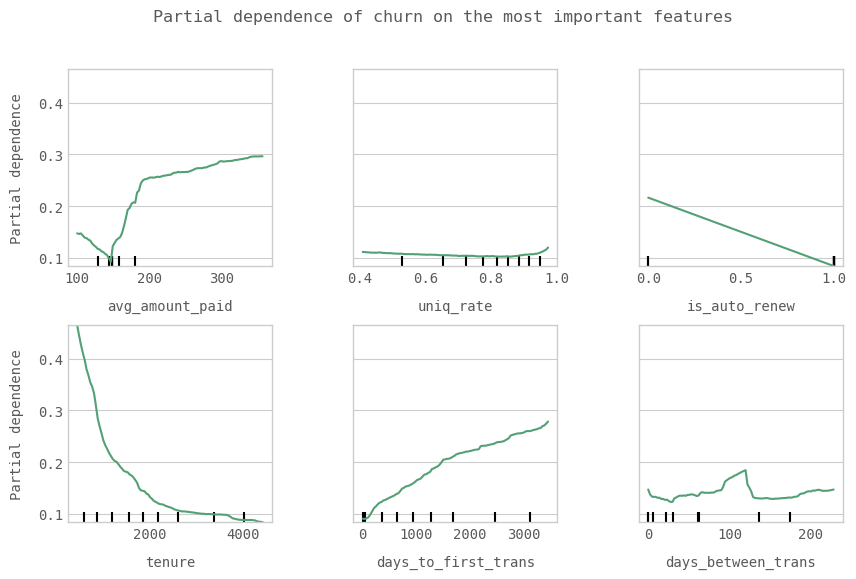

In [319]:
features = ['avg_amount_paid', 'uniq_rate', 'is_auto_renew', 'tenure', 'days_to_first_trans', 'days_between_trans']
print('Computing partial dependence plots...')
plot_style_setting()
# _, ax = plt.subplots(1,6, figsize=(12, 6))
p = plot_partial_dependence(
    rf, X_train, features, line_kw={"color": "#54a075"}, n_jobs=-1)
p.figure_.suptitle(
    'Partial dependence of churn on the most important features\n'
)
p.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('partial_denpendency_rf', dpi=100)

Computing partial dependence plots...


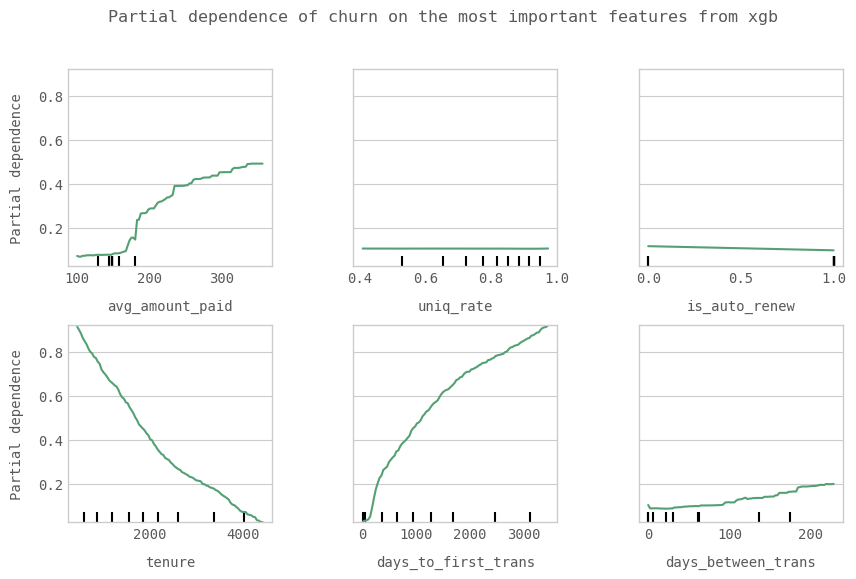

In [320]:
features = ['avg_amount_paid', 'uniq_rate', 'is_auto_renew', 'tenure', 'days_to_first_trans', 'days_between_trans']
print('Computing partial dependence plots...')
plot_style_setting()
# _, ax = plt.subplots(1,6, figsize=(12, 6))
p = plot_partial_dependence(
    xgb, X_train, features, line_kw={"color": "#54a075"}, n_jobs=-1)
p.figure_.suptitle(
    'Partial dependence of churn on the most important features from xgb\n'
)
p.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
# plt.savefig('partial_denpendency_xgb', dpi=100)

# Survival Analysis 

In customer relation management, however, we are often concerned with censored data. That is, the customer journeys end at the current point in time just because we cannot see what happens in the future. This is a kind of missing data that our previous models cannot handle. And this is where survival analysis comes into play. Survival analysis is suited for situations where for some observations an event has not yet happened, but may happen at some point in time (In this case, whether a user will churn). Survival analysis allows us to model the time to an event, also called failure or survival time. This avoids a loss of information due to aggregation. In the end, survival analysis allows us to obtain deep insights into customer relations since it is possible to model when an event will take place and not just if it will take place. If we predict that a certain customer is likely to end her contract within the next three months, special actions can be taken to keep her from churning. Survival Analysis is a set of methods used in the life sciences (mostly Epidemiology and Pharma research) to determine the probability of patient cohort survival over time. It’s a very large body of work with a great many intricate and statistically sophisticated tools, but I will only be using two of them — the Kaplan–Meier Estimator and the Cox Proportional Hazards Model.

## Survival function

The measure of interest in a survival analysis is the survival function. This function gives the probability that a customer will not churn in the period leading up to the time point t. To estimate the survival function, we will use the Kaplan-Meier Estimate in this project. It’s basically counting how many people has churn/not churned at each time point. For more information about this non-parametric method, please check [here](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator).
Also we would need to bring up the concept of censored data. Censoring is a special case of missing data. The kind of censoring we are concerned with most often is random type I right-censoring. This means that a subject's event can only be observed if it occurs before a certain point in time. In the case of churn prediction, churn must happen before the current point in time to be observed. If it hasn't happened yet, we cannot know whether a person is going to churn in the future. We do, however, know that, for the time under consideration, a person has not yet churned. This is more information than completely missing data. Since customers enter our database at different points in time, censoring times can vary between subjects.

In [57]:
sns.light_palette("seagreen").as_hex()

['#ebf3ed', '#c5decf', '#9fc9b1', '#7ab493', '#54a075', '#2e8b57']

In [58]:
sns.light_palette("purple").as_hex()

['#f3f0f3', '#dcc0dc', '#c590c5', '#ae60ae', '#973097', '#800080']

In [59]:
print(sns.light_palette("seagreen").as_hex())
print(sns.light_palette("purple").as_hex())

['#ebf3ed', '#c5decf', '#9fc9b1', '#7ab493', '#54a075', '#2e8b57']
['#f3f0f3', '#dcc0dc', '#c590c5', '#ae60ae', '#973097', '#800080']


In [60]:
# Resample the data for survival analysis
y = user_features['is_churn']
X = user_features.drop('is_churn', axis=1)
ru = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_under, y_under = ru.fit_resample(X, y)
feature_under = pd.concat([X_under, y_under], axis=1)
feature_under

msno  avg_songs_daily  \
0      1Tg5i8MlWOQZcaAxdZrmM2fw1jVDyNm83EHU8RuCxAM=        23.250000   
1      vglWL57GAoiidnhIF0Tpf+WHC6Rrv05PaWIgsaxHqzk=        34.000000   
2      lI7NxMTGeL1OCWhsXs3eldF98QP0J2NDeB5e0ttTZxA=        19.909091   
3      MKAjGv7gTqlTH22fo5ZlqJLaH3LYg6WXJj0QOzaHlNM=        14.736842   
4      m5I26RsMlstYkkUxYZmW31magv/4La409dmCurj0Lt4=        35.857143   
...                                             ...              ...   
18447  zyYx11ixa6B4bgm/o1gwD2AtwGTfVlRK1RtqJToM5R0=         6.000000   
18448  zyu0O8EOUFzTY+wWp4ORsMXl9ONDbw8SBb/UBpDyfhI=        42.363636   
18449  zz58DhHXMpGS0reh+g3F/m67RRSScr4B1CY7TG6CaCs=        41.176471   
18450  zz79F6roc15efaX72KhcGWPW2hXmE7ykGktQfm679d8=        52.000000   
18451  zz8pxGKfI7m9/4DFR19s6ixRC7u01Jo1FtTUepzIElQ=        45.500000   

       uniq_rate  avg_secs_daily  median_secs_daily listening_type  \
0       0.978495     5300.475000          3739.4500  loyalist_type   
1       0.659804     7442.192067          6115.6555  loyalist_type   
2       0.936073     3271.208000          2912.9390    normal_type   
3       0.771429     2705.180263          1046.4180    normal_type   
4       0.816733     7929.253571          5306.6340  loyalist_type   
...          ...             ...                ...            ...   
18447   1.000000     1248.828000          1248.8280  loyalist_type   
18448   0.659871     9516.106909          7342.9315  loyalist_type   
18449   0.762857     3242.956235          2253.0070    normal_type   
18450   0.914835    12538.164071         13065.0780  loyalist_type   
18451   0.897436    11138.317667          7480.7890  loyalist_type   

       no_records  payment_method_id  avg_amount_paid  tenure  \
0              27                 37       149.000000    3562   
1              23                 34       149.000000    4816   
2              11                 41       121.727273    2662   
3              19                 37       149.000000     827   
4              10                 38       149.000000     865   
...           ...                ...              ...     ...   
18447          13                 38       116.923077    1421   
18448          16                 40       149.000000    3149   
18449           5                 38       119.200000     151   
18450           1                 32       894.000000     998   
18451           4                 29       180.000000      93   

       days_to_first_trans  days_between_trans  is_auto_renew  city  \
0                     2490                   0              1    13   
1                     3810                  61              1     6   
2                     1961                 153              1    13   
3                        3                   0              1    22   
4                        1                 289              0    13   
...                    ...                 ...            ...   ...   
18447                  784                 285              0    13   
18448                 2694                  19              1    13   
18449                    6                  21              0     8   
18450                  800                   0              0    22   
18451                    0                  25              1    15   

       registered_via  is_male age_bin  is_churn  
0                   9        1   36_45         0  
1                   9        0   26_35         0  
2                   7        1   26_35         0  
3                   3        0   19_25         0  
4                   3        1   19_25         0  
...               ...      ...     ...       ...  
18447               9        1   19_25         1  
18448               9        0   26_35         1  
18449               4        1   12_18         1  
18450               3        0   26_35         1  
18451               4        1   26_35         1  

[18452 rows x 18 columns]

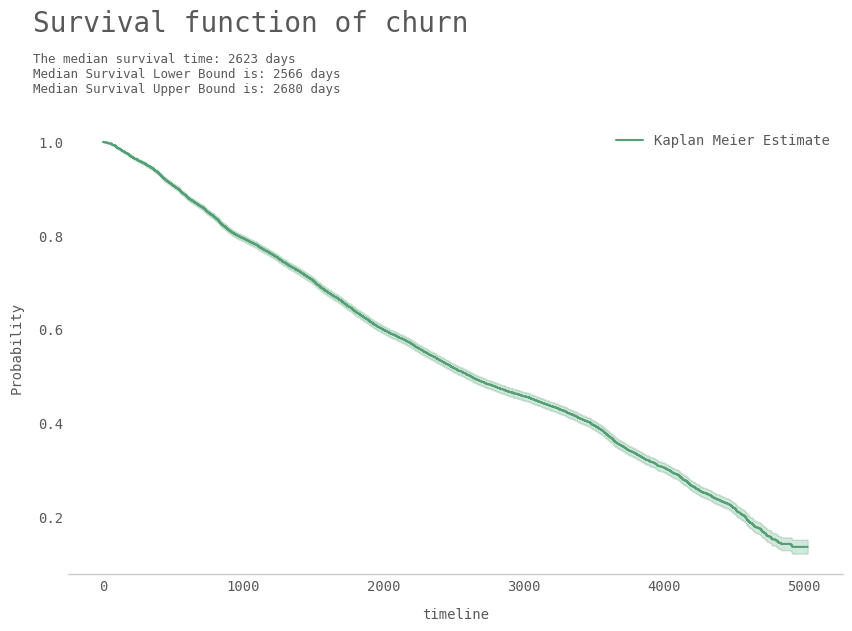

In [263]:
# ## create a kmf object
plot_style_setting()
# kmf = KaplanMeierFitter() 

# ## Fit the data into the model
# kmf.fit(feature_under['tenure'], event_observed=feature_under['is_churn'],label='Kaplan Meier Estimate')

kmfplot = kmf.plot(color='#54a075')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.ylabel('Probability')
median_ci = median_survival_times(kmf.confidence_interval_)
lower_bound, upper_bound = median_ci.loc[0.5]
plt.title('Survival function of churn', 
          fontsize=20, 
          color='#595959',
          loc='left',
          x=-0.045,
          y=1.18,
          fontname='monospace')
plt.text(-0.045, 1.03, f'''The median survival time: {kmf.median_survival_time_:0.0f} days\nMedian Survival Lower Bound is: {lower_bound:0.0f} days\nMedian Survival Upper Bound is: {upper_bound:0.0f} days\n''', 
         transform=kmfplot.transAxes,
         fontsize=9,
         color='#595959',
         fontname='monospace')

plt.savefig('kmf1', dpi=150, bbox_inches='tight')


The median survival time is 2623, that is, about 50 percent of the users do not churn before they reach a tenure duration of 2623 days. The median survival time is the time where a horizontal line at 0.5 intersects the survival curve. The counterpart to the survival function is the cumulative hazard function. It describes the cumulative risk, or the probability that the customer will have churned, up until time t.


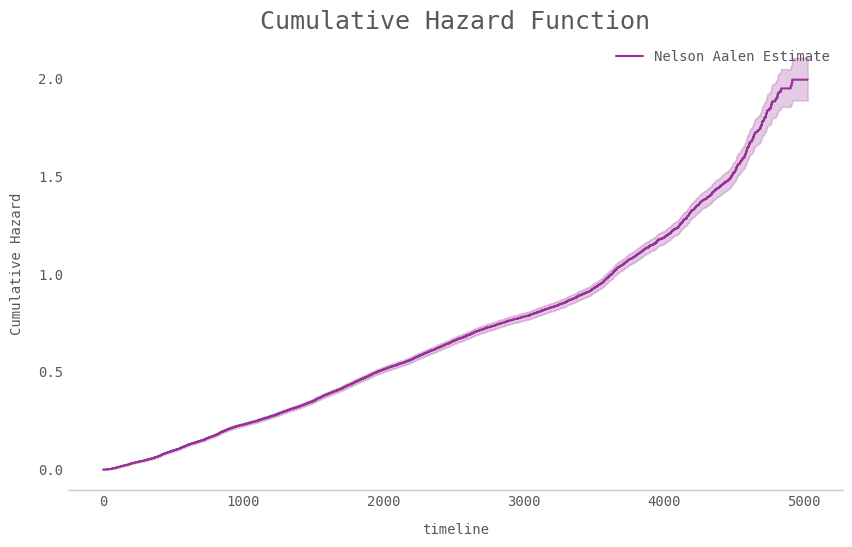

In [332]:
## create a naf object
naf = NelsonAalenFitter(nelson_aalen_smoothing=False)

## Fit the data into the model
naf.fit(feature_under['tenure'], event_observed=feature_under['is_churn'],label='Nelson Aalen Estimate')

naf.plot(color='#973097')
plt.ylabel('Cumulative Hazard')
plt.title('Cumulative Hazard Function', 
          fontsize=18, 
          color='#595959',
          fontname='monospace')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)

div = '='*35
plt.savefig('hazard_function', dpi=150, bbox_inches='tight')

Recall that we are estimating cumulative hazard functions, thus we know the rate of change of this curve is an estimate of the hazard function. The hazard rate, also called force of mortality or instantaneous event rate, describes the risk that an event will occur in a small interval around time t, given that the event has not yet happened. Since the true form of the survival function is rarely known, a part of survival analysis is concerned with its estimation. Additionally, the sum of estimates is much more stable than the point-wise estimates.

The median survival time of users with auto renewal:
	- Median Survival time is: 4055.0 days
	- Survival Lower Bound is: 3958.00 days
	- Survival Upper Bound is: 4137.00 days

The median survival time of users without auto renewal:
	- Median Survival time is: 1424.0 days
	- Survival Lower Bound is: 1379.00 days
	- Survival Upper Bound is: 1465.00 days



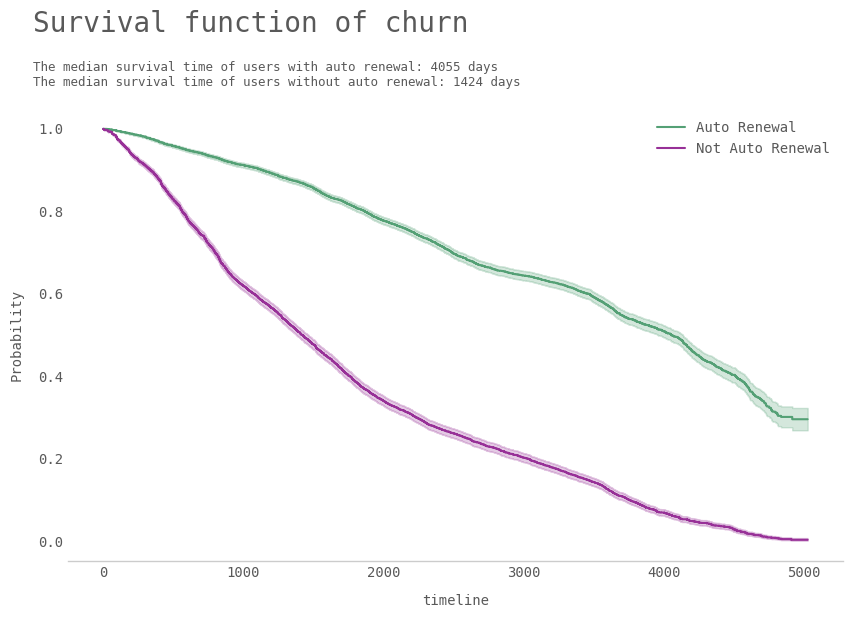

In [265]:
## create a kmf object
kmf_1 = KaplanMeierFitter() 
kmf_2 = KaplanMeierFitter() 

## Fit the data into the model
kmf_1.fit(feature_under.loc[feature_under.is_auto_renew == 1, 'tenure'], event_observed=feature_under.loc[feature_under.is_auto_renew == 1, 'is_churn'], label='Auto Renewal')
kmf_2.fit(feature_under.loc[feature_under.is_auto_renew == 0, 'tenure'], event_observed=feature_under.loc[feature_under.is_auto_renew == 0, 'is_churn'],label='Not Auto Renewal')

kmf_1_plot = kmf_1.plot(color='#54a075')
kmf_2_plot = kmf_2.plot(color='#973097')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)

div = '='*35
renewal_median_ci = median_survival_times(kmf_1.confidence_interval_)
renewal_lower_bound, renewal_upper_bound = renewal_median_ci.loc[0.5]

nrenewal_median_ci = median_survival_times(kmf_2.confidence_interval_)
nrenewal_lower_bound, nrenewal_upper_bound = nrenewal_median_ci.loc[0.5]
plt.title('Survival function of churn', 
          fontsize=20, 
          color='#595959',
          loc='left',
          x=-0.045,
          y=1.15,
          fontname='monospace')
plt.text(-0.045, 1.05, f'''The median survival time of users with auto renewal: {kmf_1.median_survival_time_:0.0f} days\nThe median survival time of users without auto renewal: {kmf_2.median_survival_time_:0.0f} days''', 
         transform=kmf_1_plot.transAxes,
         fontsize=9,
         color='#595959',
         fontname='monospace')
plt.ylabel('Probability')

print(f'{div}\nThe median survival time of users with auto renewal:')

print(f'\t- Median Survival time is: {kmf_1.median_survival_time_} days')
print(f'\t- Survival Lower Bound is: {renewal_lower_bound:0.2f} days')
print(f'\t- Survival Upper Bound is: {renewal_upper_bound:0.2f} days\n')

print('The median survival time of users without auto renewal:')
print(f'\t- Median Survival time is: {kmf_2.median_survival_time_} days')
print(f'\t- Survival Lower Bound is: {nrenewal_lower_bound:0.2f} days')
print(f'\t- Survival Upper Bound is: {nrenewal_upper_bound:0.2f} days\n{div}\n')
plt.savefig('kmf2', dpi=150, bbox_inches='tight')


We have two survival curves , one for each cohort. From the curves, it is evident that the users, who have activated the auto renewal service, have better retention as compared to the users who have not activated the service. At any point t across the timeline, the survival probability of the cohort in purple is less than the cohort in green. For the cohort in purple, the survival probability is decreasing with high rate between 500-1000 days after registration and it gets relatively better after that; however, for the green cohort, the rate of decrease in survival rate is fairly constant and flat. Therefore, for the cohort , which has not activated the auto renewal service, efforts should be made to retain the users in their first 500-1000 days. Here the difference between survival functions is very obvious, and performing a statistical test seems pedantic. If the curves are more similar, or we possess less data, we may be interested in performing a statistical test. We can do more such cohort analysis from the survival curves of the different cohorts, say gender. 

The median survival time of male users: 2520.0
The median survival time of female users: 2746.0



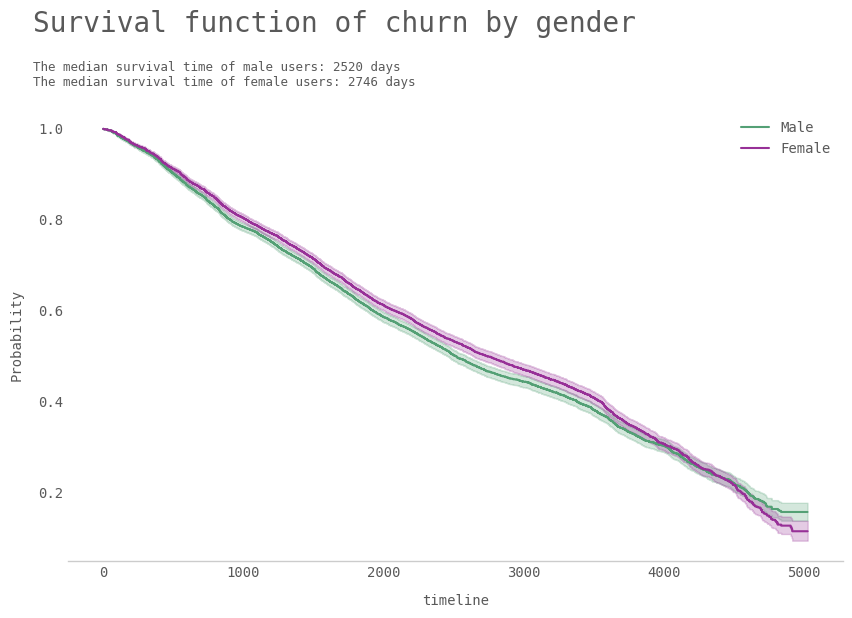

In [266]:
## create a kmf object
kmf_male = KaplanMeierFitter() 
kmf_female = KaplanMeierFitter() 

## Fit the data into the model
kmf_male.fit(feature_under.loc[feature_under.is_male == 1, 'tenure'], event_observed=feature_under.loc[feature_under.is_male == 1, 'is_churn'], label='Male')
kmf_female.fit(feature_under.loc[feature_under.is_male == 0, 'tenure'], event_observed=feature_under.loc[feature_under.is_male == 0, 'is_churn'],label='Female')

kmf_male_plot = kmf_male.plot(color='#54a075')
kmf_female_plot = kmf_female.plot(color='#973097')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.title('Survival function of churn by gender', 
          fontsize=20, 
          color='#595959',
          loc='left',
          x=-0.045,
          y=1.15,
          fontname='monospace')
plt.text(-0.045, 1.05, f'''The median survival time of male users: {kmf_male.median_survival_time_:0.0f} days\nThe median survival time of female users: {kmf_female.median_survival_time_:0.0f} days''', 
         transform=kmf_male_plot.transAxes,
         fontsize=9,
         color='#595959',
         fontname='monospace')
plt.ylabel('Probability')

div = '='*35
print(f'''{div}\nThe median survival time of male users: {kmf_male.median_survival_time_}\nThe median survival time of female users: {kmf_female.median_survival_time_}\n{div}\n''')
plt.savefig('kmf3', dpi=150, bbox_inches='tight')

This cohort analysis represents the limited use case of the potential of the survival analysis because we are using it for the aggregated level of the data. In order to check the effect of multiple user characteristics on the risk of churn and create the survival curves for even the individual users, we will leverage the power of Cox proportional hazards model. The idea behind Cox proportional hazard model is that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time.

In [66]:
dummy_under_df = pd.get_dummies(feature_under[cat_cols].astype(str), drop_first=True)
print(dummy_under_df.shape)
feature_under_dm = feature_under.drop(cat_cols, axis=1)
feature_under_dm = pd.concat([feature_under_dm, dummy_under_df], axis=1).drop(userid, axis=1)
print(feature_under_dm.shape)

(18452, 54)
(18452, 66)


## Cox proportional hazards model

In [ ]:
cph = CoxPHFitter()
cph.fit(feature_under_dm, duration_col='tenure', event_col='is_churn')
cox_summary = cph.summary[cph.summary.p <= 0.01].sort_values('exp(coef)', ascending=False)
cox_summary

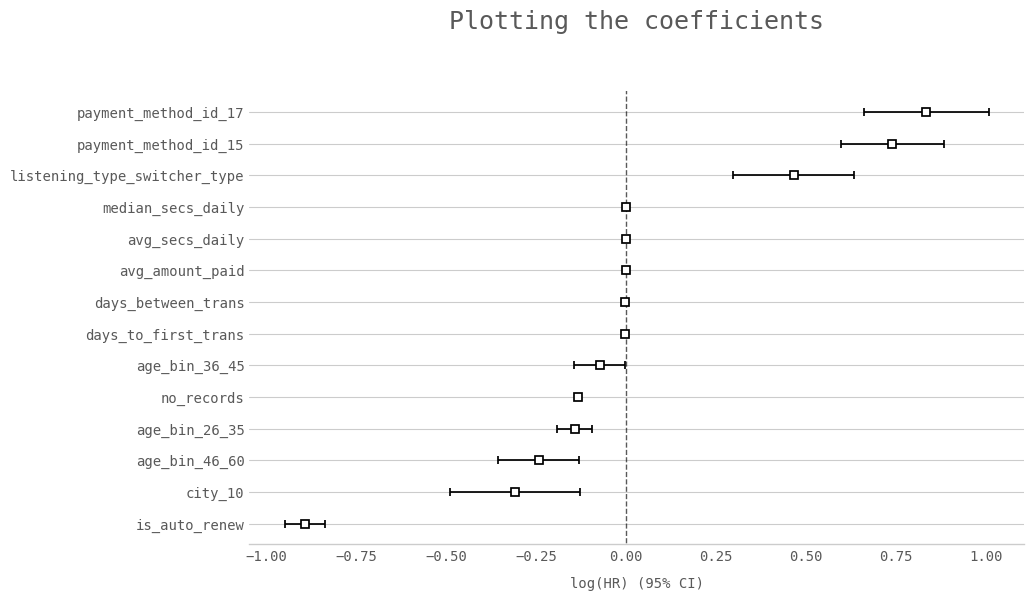

In [275]:
selected_features = cox_summary.index.to_list()
time = ['tenure']
cph_s = CoxPHFitter()
cph_s.fit(feature_under_dm[selected_features+time+target], duration_col='tenure', event_col='is_churn')
cph_s.plot()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Plotting the coefficients', 
          fontsize=18, 
          color='#595959',
          loc='center',
          y=1.12,
          fontname='monospace')
plt.savefig('cph1', dpi=150, bbox_inches='tight')

In a cox proportional hazards model, coefficients are interpreted similar to a logistic regression. From the untransformed coefficient we can only draw conclusions about the direction of the effect. Looking at the coefficient for `is_auto_renew` I see that the risk of churning is lower for those who activate auto renewal service to those who don't. By transforming them using the exponential function, interpretation gets easier. Luckily, the model's summary already does the dirty work for us. We can find the transformed coefficients at the `exp(coef)` column, which are called the hazard ratio. The hazard to churn decreases by roughly 75 percent for users who activate auto renewal service to those who don't. For continuous covariates, interpretation changes slightly. For example, A one-unit increase in `uniq_rate` (a ratio of unique songs and all songs that a user has listened to) increases the hazard of churning by a factor of one point two five.

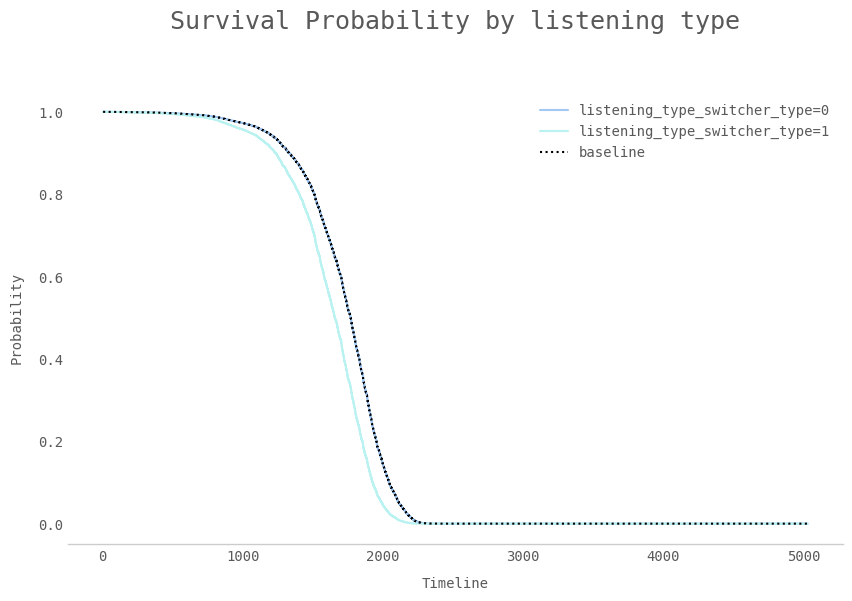

In [279]:
# construct cmap
cmap = ListedColormap(sns.color_palette('pastel').as_hex())
cph_s.plot_partial_effects_on_outcome(covariates='listening_type_switcher_type', values=[0, 1], cmap=cmap)
plt.title('Survival Probability by listening type')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Survival Probability by listening type', 
          fontsize=18, 
          color='#595959',
          loc='center',
          y=1.12,
          fontname='monospace')
plt.grid(False)
plt.xlabel('Timeline')
plt.ylabel('Probability')
plt.savefig('cph2', dpi=150, bbox_inches='tight')

It's clear that users that enjoy the whole songs(or at least 50%) without skipping the song are more likely to stick around. Well, it makes sense to me that users keeping switching the songs without actually listening them have worse retention.

In [85]:
results = logrank_test(feature_under_dm.loc[feature_under_dm['listening_type_switcher_type']==1, 'tenure'], 
                       feature_under_dm.loc[feature_under_dm['listening_type_switcher_type']==0, 'tenure'], 
                       feature_under_dm.loc[feature_under_dm['listening_type_switcher_type']==1, 'is_churn'], 
                       feature_under_dm.loc[feature_under_dm['listening_type_switcher_type']==0, 'is_churn'], alpha=.99)

results.summary

test_statistic         p   -log2(p)
0       18.993507  0.000013  16.218268

We can compare whether the churn generation process of the two populations are equal bu using `logrank_test`. According to the document, the logrank test statistic is calculated from the differences between the observed churns for a group and expected churns, under the null hypothesis that all groups share the same survival curve, summed across all ordered churns times. Here we have a p-value smaller than 0.01, which is statistically significant.

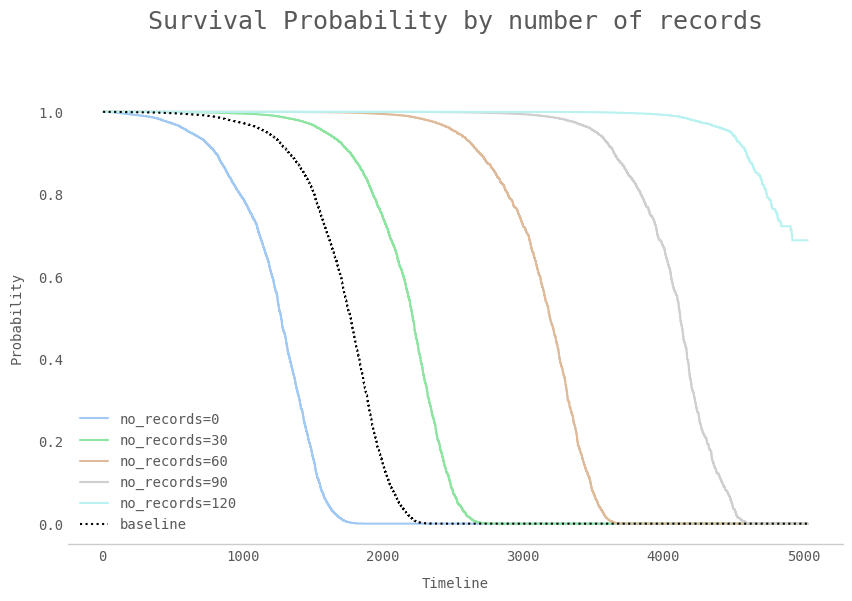

In [282]:

cph_s.plot_partial_effects_on_outcome(covariates='no_records', values=np.arange(0, 125, 30), cmap=cmap)
plt.title('Survival Probability by number of records', 
          fontsize=18, 
          color='#595959',
          loc='center',
          y=1.12,
          fontname='monospace')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.xlabel('Timeline')
plt.ylabel('Probability')
plt.savefig('cph3', dpi=150, bbox_inches='tight')

As expected, users that are more active and more transactions have better retention.

In [72]:
# I want to see the Survival curve at the individual level. 
user_to_see = list(np.random.choice(feature_under.msno, 5))
user_df = pd.concat([feature_under['msno'], feature_under_dm], axis=1).set_index('msno')
sample_user = user_df.loc[user_to_see, :]
sample_user

avg_songs_daily  uniq_rate  \
msno                                                                       
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=        32.935484   0.842311   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=        28.090909   0.889968   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=        96.000000   0.851763   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=        24.612903   0.961992   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=        26.416667   0.870662   

                                              avg_secs_daily  \
msno                                                           
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=     5846.763161   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=     6058.938682   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=    22024.233538   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=     5714.741194   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=     4215.194917   

                                              median_secs_daily  no_records  \
msno                                                                          
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=          5096.2500          10   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=          4021.7445          23   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=         21234.7080          27   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=          5151.9540          15   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=          3213.9745          21   

                                              avg_amount_paid  tenure  \
msno                                                                    
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=       180.000000    3868   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=       149.000000    4465   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=       149.000000    4032   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=        99.000000     705   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=       144.238095     848   

                                              days_to_first_trans  \
msno                                                                
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=                 3301   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=                 3459   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=                 2964   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=                    0   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=                    0   

                                              days_between_trans  \
msno                                                               
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=                  10   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=                  61   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=                   0   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=                   0   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=                  27   

                                              is_auto_renew  ...  \
msno                                                         ...   
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=              1  ...   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=              1  ...   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=              1  ...   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=              1  ...   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=              1  ...   

                                              registered_via_3  \
msno                                                             
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=                 0   
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=                 0   
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=                 0   
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=                 0   
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=                 0   

                                              registered_via_4  \
msno                           

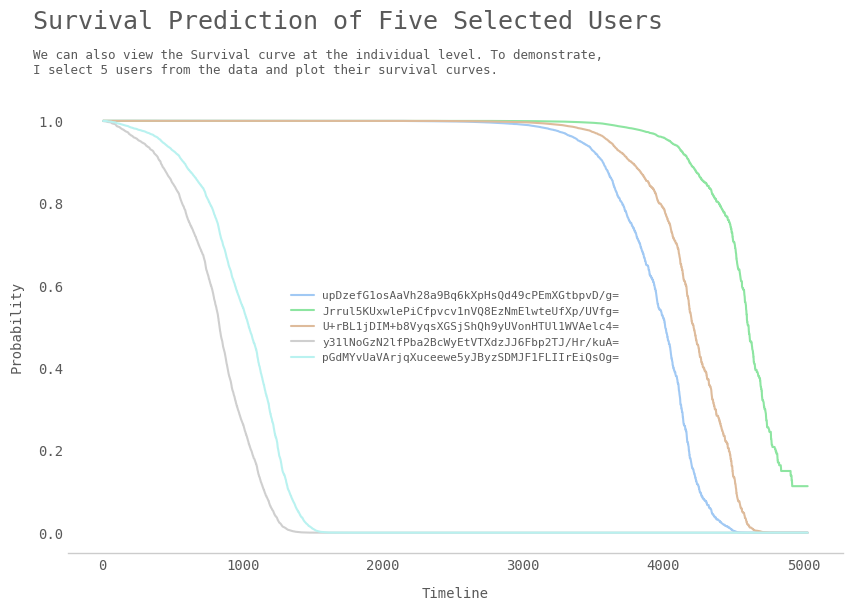

In [293]:
# Customers can be identified with the help of the number mentioned against each curve.
plot_style_setting()
cph_s_pred_plot = cph_s.predict_survival_function(sample_user).plot(cmap=cmap)
plt.title('Survival Prediction of Five Selected Users', 
          fontsize=18, 
          color='#595959',
          loc='left',
          x=-0.045,
          y=1.14,
          fontname='monospace')
plt.text(-0.045, 1.06, f'''We can also view the Survival curve at the individual level. To demonstrate, \nI select 5 users from the data and plot their survival curves.''', 
         transform=cph_s_pred_plot.transAxes,
         fontsize=9,
         color='#595959',
         fontname='monospace')

plt.legend(prop={'size': 8})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.xlabel('Timeline')
plt.ylabel('Probability')
plt.savefig('cph4', dpi=150, bbox_inches='tight')

We can also predict the expected time until churn. The expected median survival time for the five users are shown below.

In [301]:
cph_s_pred = cph_s.predict_median(sample_user).to_frame('median_value')
cph_s_pred

median_value
upDzefG1osAaVh28a9Bq6kXpHsQd49cPEmXGtbpvD/g=        4012.0
Jrrul5KUxwlePiCfpvcv1nVQ8EzNmElwteUfXp/UVfg=        4607.0
U+rBL1jDIM+b8VyqsXGSjShQh9yUVonHTUl1WVAelc4=        4215.0
y31lNoGzN2lfPba2BcWyEtVTXdzJJ6Fbp2TJ/Hr/kuA=         833.0
pGdMYvUaVArjqXuceewe5yJByzSDMJF1FLIIrEiQsOg=        1042.0

# Customer Life Time Value 

### Historical CLV
I first compute the historical CLV, which sums revenue of all past transactions of a user and multiply by profit margin. In this project we don't have data regarding profit margin and will hence ignore this element. However, this approach doesn't consider changes in user behavior. So if users change their interests and the way they purchase, it will affect the outcome.

In [82]:
# Calculate the historical clv
clv_historical_df = user_data_sample.groupby('msno')['actual_amount_paid'].agg(clv_historical='sum').reset_index()

# Merge the result back to the features data set
user_features = user_features.merge(clv_historical_df, on='msno')

### Traditional CLV
CLV = Average Revenue * Monthly Retention Rate / Monthly Churn Rate
Using this CLV formula, we can take into account all possible changes of revenue during a specific period of time. In this project, I do this by creating monthly cohorts and their retention rate. Note that I didn't include the user acquisition cost and the discount rate for simplicity. We should do so if we have those data at hand.

In [302]:
# Data preprcessing for monthly corhort 
user_data_sample['transaction_date_floor'] = user_data_sample['transaction_date'] - pd.Timedelta('1 day') * (user_data_sample['transaction_date'].dt.day - 1)
user_data_sample['first_month'] = user_data_sample.groupby('msno')['transaction_date_floor'].transform(min)
user_data_sample['month_after_fist_day'] = ((user_data_sample['transaction_date_floor'] - user_data_sample['first_month']) / np.timedelta64(1, "M")).round(0).astype(int)

In [303]:
# Count the number of unique values per user id
cohort_data = user_data_sample.groupby(['first_month', 'month_after_fist_day'])\
                              .agg({'msno':pd.Series.nunique, 
                                    'actual_amount_paid': 'mean'})\
                              .reset_index()

# Create a pivot table
cohort_counts = cohort_data.pivot(index='first_month', columns='month_after_fist_day', values='msno')
cohort_payment_avg = cohort_data.pivot(index='first_month', columns='month_after_fist_day', values='actual_amount_paid')
newest = cohort_payment_avg.loc['2017-03-01', 0]

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention_table = cohort_counts.divide(cohort_sizes, axis=0)

# Get the churn table
churn_table = 1 - retention_table

# # Compute the average retention rate for each month
# retention_table.loc['average_value_of_the_month'] = retention_table.mean()
# churn_table.loc['average_value_of_the_month'] = churn_table.mean()
# cohort_payment_avg.loc['average_value_of_the_month'] = cohort_payment_avg.mean()

# Drop the fisrt column since it's always 100%
retention_table.drop(0, axis=1, inplace=True)
churn_table.drop(0, axis=1, inplace=True)
cohort_payment_avg.drop(0, axis=1, inplace=True)

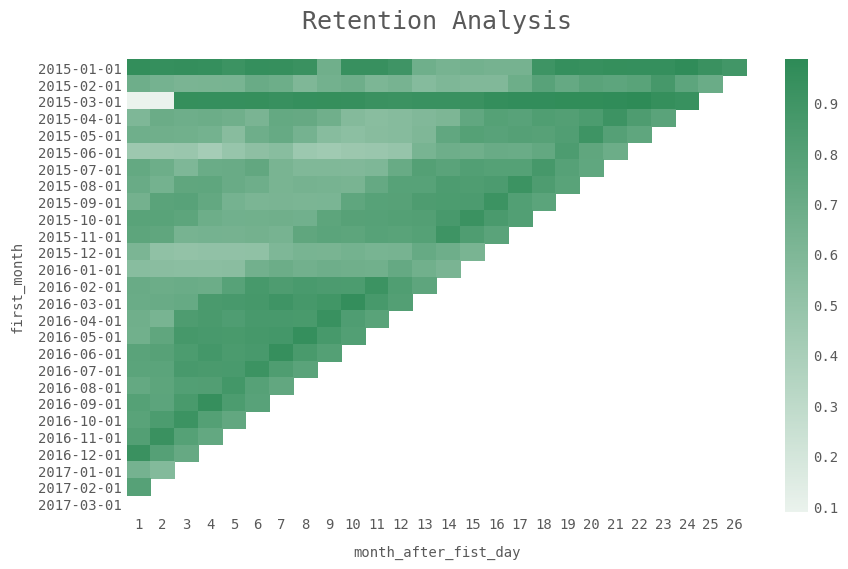

In [324]:
retention_table_to_plot = retention_table.copy()
retention_table_to_plot.index = retention_table_to_plot.index.astype(str)
palette = sns.light_palette("seagreen", as_cmap=True)
g = sns.heatmap(retention_table_to_plot, cmap=palette)
plt.title('Retention Analysis', 
          fontsize=18, 
          color='#595959',
          fontname='monospace',
          y=1.05)
plt.savefig('clv1', dpi=150, bbox_inches='tight')

In [ ]:
# Calculate the traditional CLV 
clv_traditional = (cohort_payment_avg * (retention_table / churn_table))\
                    .mean(axis=1)\
                    .fillna(newest)\
                    .round(0)\
                    .to_frame()\
                    .reset_index()\
                    .rename({0:'clv_traditional'}, axis=1)

# Merge the result back to the dataset
clv_traditional_df = user_data_sample.merge(clv_traditional).groupby('msno', as_index=False)['clv_traditional'].first()
user_features = user_features.merge(clv_traditional_df, on='msno')

# Conclusion

In this project, I start off performing churn prediction with several machine learning models, proceed with the survival analysis and finish the project with customer lifetime value calculation. By leveraging the insights drawn from these analyses, we are able to come up with more accurate user targeting strategies. From the churn prediction process, we know what kind of users are more likely to churn by investigating each feature's effect on churning. By performing survival analysis, we obtain deep insights into customer relations since it is possible to model when a churn event will take place and not just if it will take place. Lastly, customer lifetime value gives us a clear look at the benefit of acquiring and keeping any given customer. Not all customers are created equal. In fact, the top 1% of e-commerce customers are worth up to 18 times more than average customers. For simplicity, I didn't consider the cost of acquisition(COC), which is extremely important when it comes to calculating a precise CLV. Trying to manage customer churn is no easy task. However, we can still uncover a good number of insights that allow us to drive strategies and make informed decisions based on data. These insights will enable us to understand our users when it comes to churning and building alert systems and campaigns. 